In [58]:
 import sys
! whoami
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)

orion
/opt/jupyterhub/bin/python3
3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=2, releaselevel='final', serial=0)


In [59]:
# Dependencies - adjust for the user's envrionment
# sudo /opt/jupyterhub/bin/python3 -m pip install xlrd
# sudo /opt/jupyterhub/bin/python3 -m pip install sklearn

In [60]:
## https://towardsdatascience.com/concrete-compressive-strength-prediction-using-machine-learning-4a531b3c43f3

# Concrete Compressive Strength
The Compressive Strength of Concrete determines the quality of Concrete. 
The strength is determined by a standard crushing test on a concrete cylinder, that requires engineers to build small concrete cylinders with different combinations of raw materials and test these cylinders for strength variations with a change in each raw material. 
The recommended wait time for testing the cylinder is 28 days to ensure correct results, although there are formulas for making estimates from shorter cure times.
The formal 28-day approach consumes a lot of time and labor to prepare different prototypes and test them. 
Also, this method is prone to human error and one small mistake can cause the wait time to drastically increase.

One way of reducing the wait time and reducing the number of combinations to try is to make use of digital simulations, where we can provide information to the computer about what we know and the computer tries different combinations to predict the compressive strength.
This approach can reduce the number of combinations we can try physically and reduce the total amount of time for experimentation. 
But, to design such software we have to know the relations between all the raw materials and how one material affects the strength. 
It is possible to derive mathematical equations and run simulations based on these equations, but we cannot expect the relations to be same in real-world. 
Also, these tests have been performed for many numbers of times now and we have enough real-world data that can be used for predictive modelling.

In this notebook, we are going to analyse a Concrete Compressive Strength dataset and build a Machine Learning Model to predict the compressive strength. 



## Dataset Description

The dataset consists of 1030 instances with 9 attributes and has no missing values. 
There are 8 input variables and 1 output variable. 
Seven input variables represent the amount of raw material (measured in $kg/m^3$) and one represents Age (in Days). 
The target variable is Concrete Compressive Strength measured in (MPa — Mega Pascal). 
We shall explore the data to see how input features are affecting compressive strength.

## Approach

1) Get the database from a repository 

2) Import/install support packages (if install required, either on your machine, or contact network admin to do a root install)

3) EDA


In [61]:
#Get database -- use the Get Data From URL Script
#Step 1: import needed modules to interact with the internet
import requests
#Step 2: make the connection to the remote file (actually its implementing "bash curl -O http://fqdn/path ...")
remote_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls' # an Excel file
response = requests.get(remote_url) # Gets the file contents puts into an object
output = open('concreteData.xls', 'wb') # Prepare a destination, local
output.write(response.content) # write contents of object to named local file
output.close() # close the connection

### Import/install support packages
Here we install necessary support packages, and run the cell.  

In [62]:
### Import/install support packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Next we will try to read the data file

In [63]:
data = pd.read_excel("concreteData.xls")

In [64]:
len(data)

1030

In [65]:
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Rename the columns to simpler names, notice use of a set constructor.
Once renamed, again look at the first few rows

In [66]:
req_col_names = ["Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer",
                 "CoarseAggregate", "FineAggregate", "Age", "CC_Strength"]
curr_col_names = list(data.columns)

mapper = {}
for i, name in enumerate(curr_col_names):
    mapper[name] = req_col_names[i]

data = data.rename(columns=mapper)

data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CC_Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## Exploratory Data Analysis

The first step in a Data Science project is to understand the data and gain insights from the data before doing any modelling. This includes checking for any missing values, plotting the features with respect to the target variable, observing the distributions of all the features and so on. Let us import the data and start analysing.

First we check for null values, as the database grows, one can expect null values, so check for presence. 
We wont act in this case, but concievably would in future iterations.

In [67]:
data.isna().sum()

Cement              0
BlastFurnaceSlag    0
FlyAsh              0
Water               0
Superplasticizer    0
CoarseAggregate     0
FineAggregate       0
Age                 0
CC_Strength         0
dtype: int64

Lets explore the database a little bit

In [68]:
data.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CC_Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Let us check the correlations between the input features, this will give an idea about how each variable is affecting all other variables. 

A pairwise plot is a useful graphical step that lets explore relationships between database fields for all records.

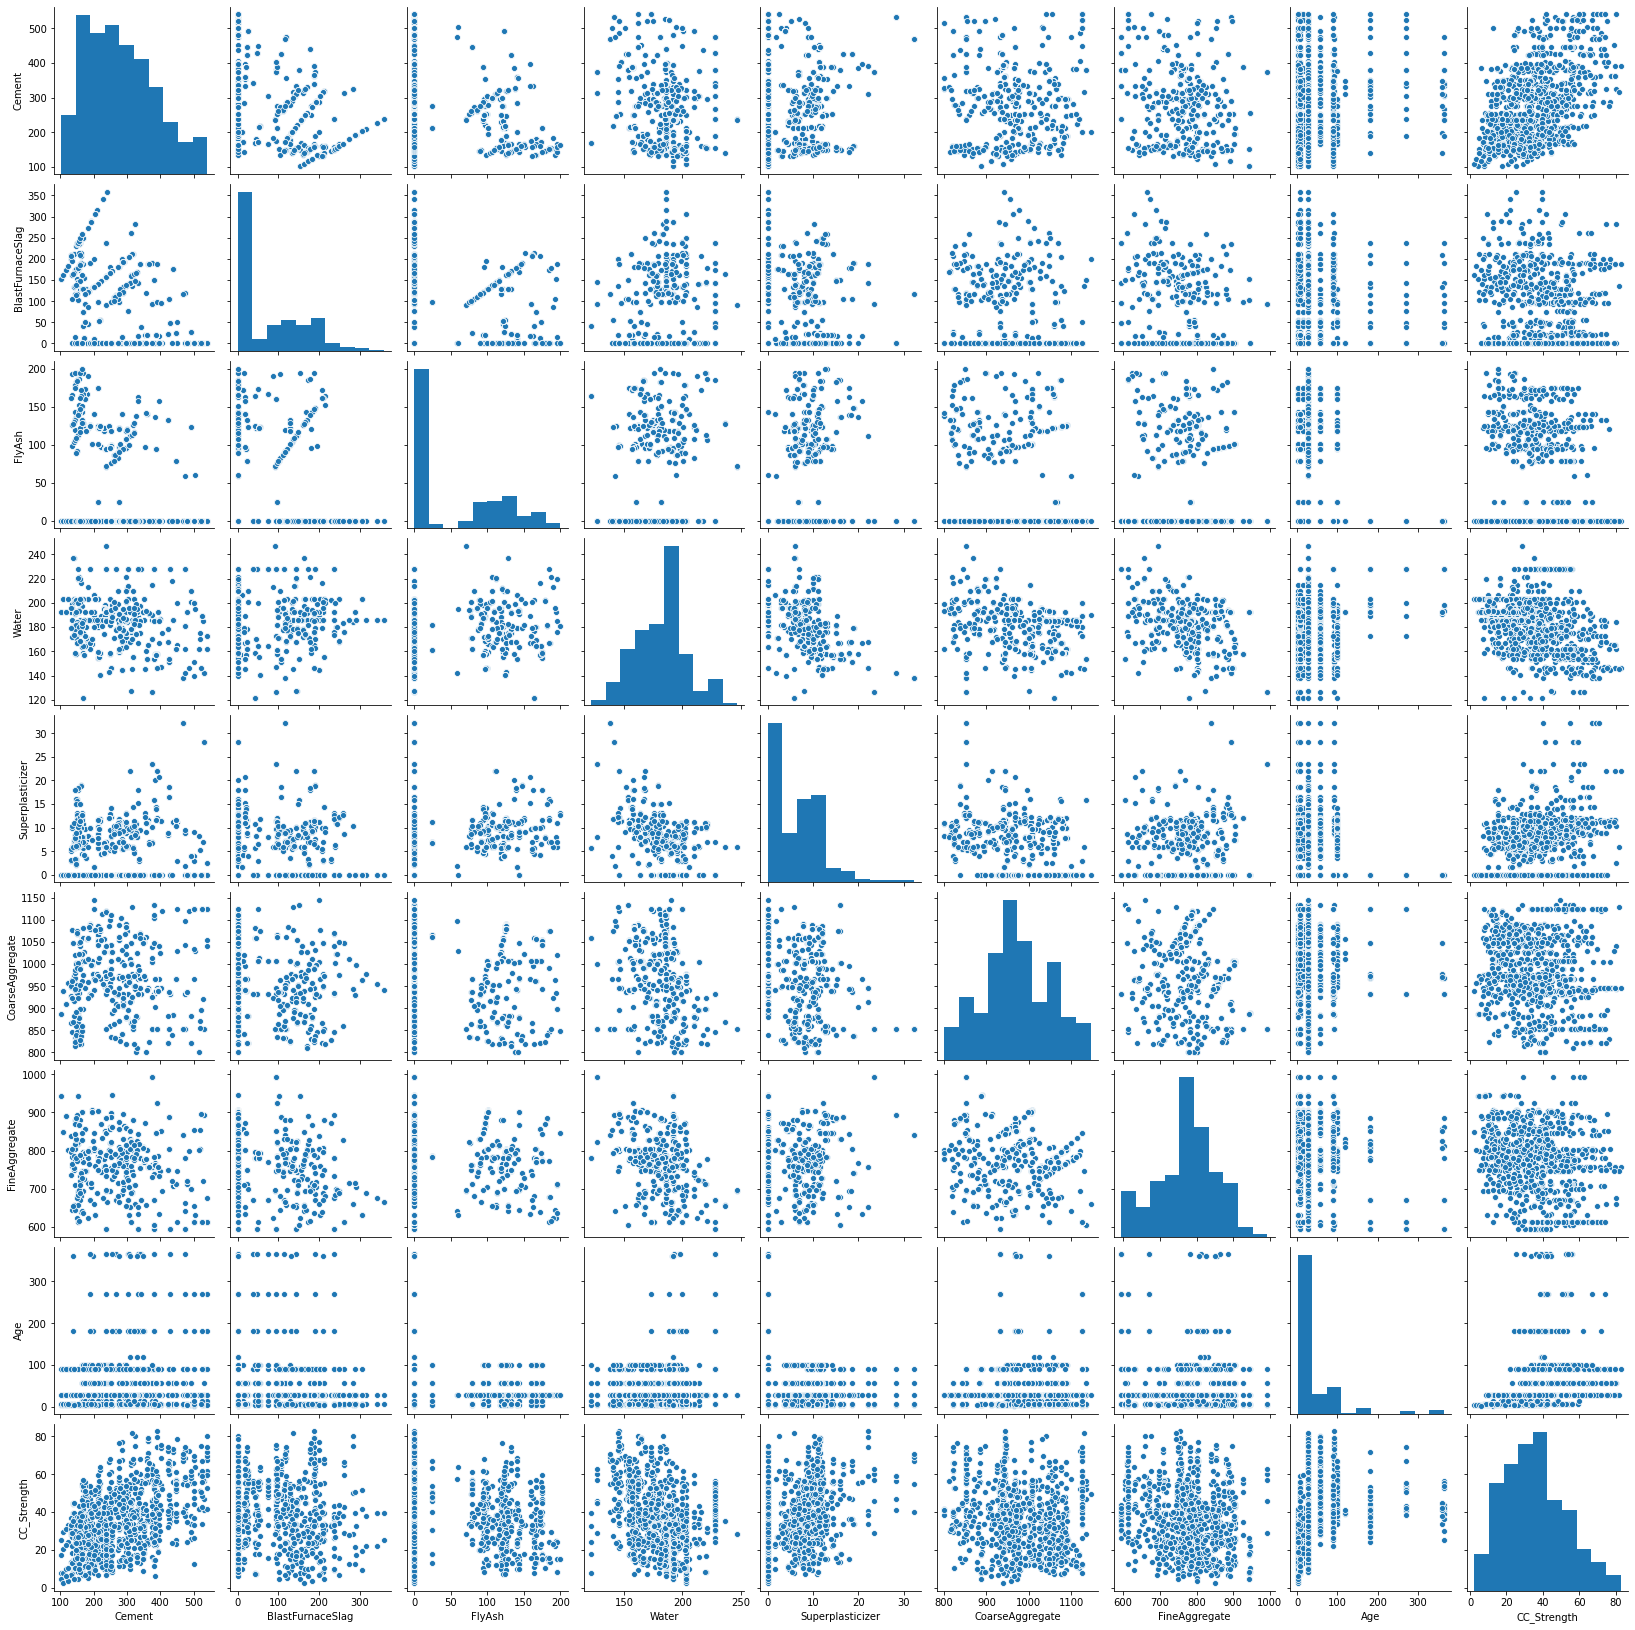

In [69]:
sns.pairplot(data)
plt.show()

The last row of this plot is informative it shows the relationship of strength to different proportions of components as well as a distribution of strength. There seems to be no high correlation between independant variables (features). This can be further confirmed by plotting the Pearson Correlation coefficients between the features.
Here we use a heatmap, which will display the correlation coefficient for each variable pair.  A variable is always self-correlated so those value will be 1.0

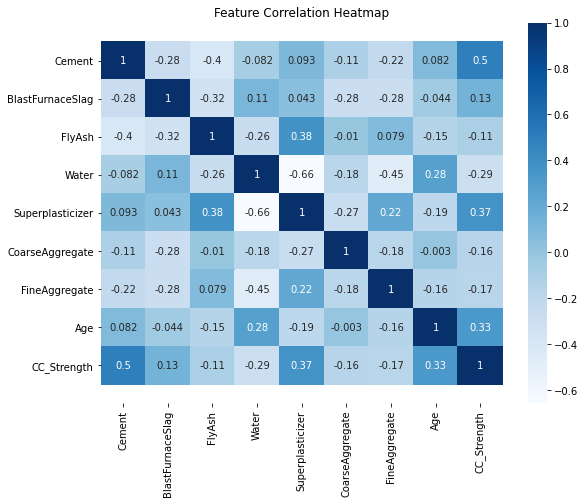

In [70]:
corr = data.corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Initial Observations

The high correlations (> 0.3) between Compressive strength and other features are for Cement, Age and Super plasticizer.  Notice water has a negative correlation which is well known and the reason for dry mixtures in high performance concrete. Super Plasticizer has a negative high correlation with Water (also well known, SP is used to replace water in the blends and provide necessary workability), positive correlations with Fly ash and Fine aggregate.

We can further analyze these correlations visually by plotting these relations.


In [71]:
data.columns

Index(['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
       'CoarseAggregate', 'FineAggregate', 'Age', 'CC_Strength'],
      dtype='object')

Text(0.5, 1.0, 'Compressive Strength Distribution')

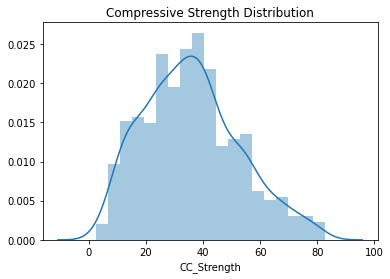

In [72]:
ax = sns.distplot(data.CC_Strength)
ax.set_title("Compressive Strength Distribution")

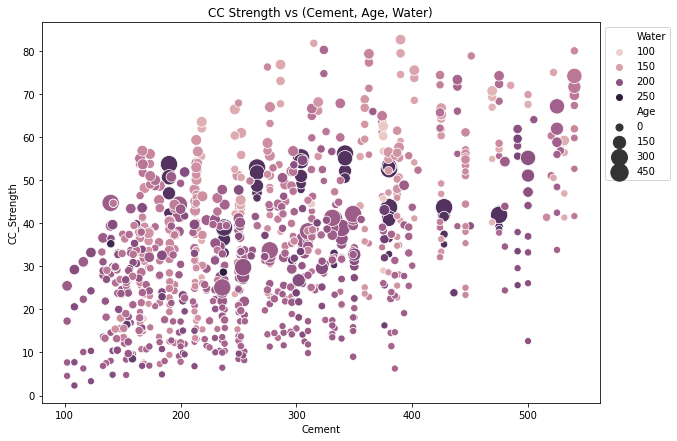

In [73]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="CC_Strength", x="Cement", hue="Water", size="Age", data=data, ax=ax, sizes=(50, 300))
ax.set_title("CC Strength vs (Cement, Age, Water)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

### Observations from Strength vs (Cement, Age, Water)

<li>Compressive strength increases with amount of cement</li>
<li>    Compressive strength increases with age</li>
<li>    Cement with low age requires more cement for higher strength</li>
<li>    The older the cement is the more water it requires</li>
<li>    Concrete strength increases when less water is used in preparing it</li>



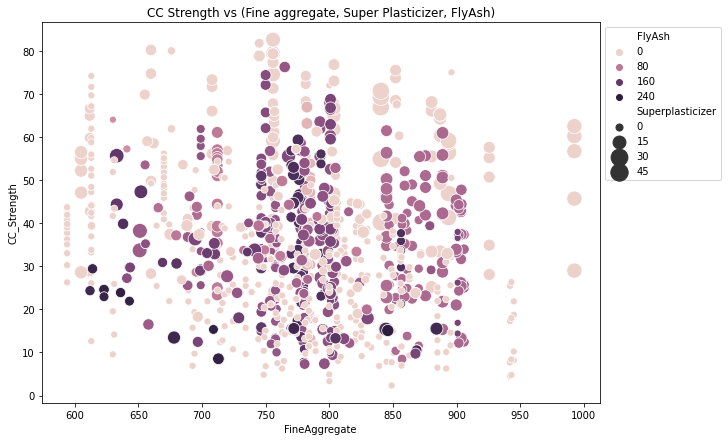

In [74]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="CC_Strength", x="FineAggregate", hue="FlyAsh", size="Superplasticizer", 
                data=data, ax=ax, sizes=(50, 300))
ax.set_title("CC Strength vs (Fine aggregate, Super Plasticizer, FlyAsh)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()


### Observations from CC Strength vs (Fine aggregate, Super Plasticizer, FlyAsh)

<li>As Flyash increases the strength decreases</li>
<li>Strength increases with Super plasticizer</li>



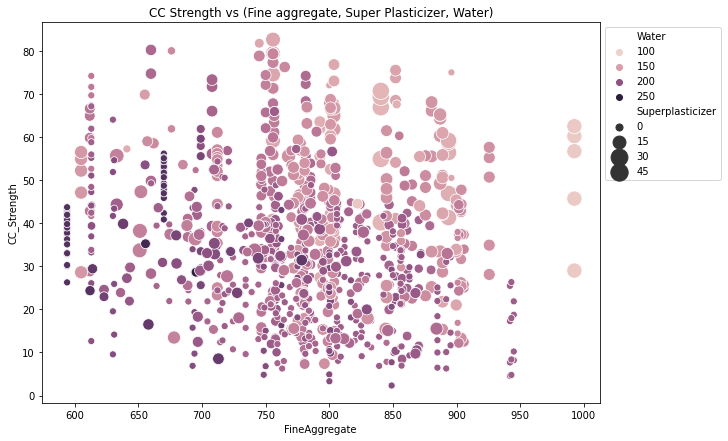

In [75]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="CC_Strength", x="FineAggregate", hue="Water", size="Superplasticizer", 
                data=data, ax=ax, sizes=(50, 300))
ax.set_title("CC Strength vs (Fine aggregate, Super Plasticizer, Water)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

### Observations from CC Strength vs (Fine aggregate, Super Plasticizer, Water)

<li>Strength decreases with increase in water, strength increases with increase in Super plasticizer (already from above plots)</li>
<li>More Fine aggregate is used when less water, more Super plasticizer is used.</li>


Although we are making conclusions by observing the scatter plots, there is an underlying non linear interaction between features which we cannot visualize.

We can visually understand 2D, 3D and max up to 4D plots (by 4D I mean color and size represented by features) as shown above, we can further use row wise and column wise plotting features by `seaborn` to do further analysis, but still we lack the ability to track all these correlations by ourselves. 

We can perform non-linear regression on a power-law model of the data (saved for later) or use a Machine Learning Approach to capture these relations and give better insights into the problem.

Fom here we will start processing the data and feed it to machine learning models to correctly predict the Compressive Strength of Concrete given the input features.


## Data Preprocessing

Separating Input Features and Target Variable.


In [76]:
X = data.iloc[:,:-1]         # Features - All columns but last
y = data.iloc[:,-1]          # Target - Last Column

Splitting data into Training and Test splits.

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Scaling

Standardizing the data i.e. to rescale the features to have a mean of zero and standard deviation of 1.

In [78]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

The scaler is fit on the training data and not on testing data. Since, we are training our model on rescaled Training data and the model performs well when the testing data follows same distribution. And if the scaler is fit on testing data again, this would result in testing data having a different mean and standard deviation. Resulting in loss of performance.

## Model Building

Training Machine Learning Algorithms on the training data and making predictions on Test data.
### Linear Regression

The Go-to method for Regression problems.
The Algorithm assigns coefficients to each input feature to form a linear relation between input features and target variable, so as to minimize an objective function.
The objective function used in this case is Mean Squared Error.
There are three versions of Linear Regression
1) Linear Regression - No regularisation

2) Lasso Regression - L1 regularisation (Tries to push coefficients to zero)

3) Ridge Regression - L2 regularisation (Tries to keep coefficients as low as possible)

We will compare these three algorithms


In [79]:
# Importing models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Linear Regression
lr = LinearRegression()
# Lasso Regression
lasso = Lasso()
# Ridge Regression
ridge = Ridge()

# Fitting models on Training data 
lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

# Making predictions on Test data
y_pred_lr = lr.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

#### Evaluation
Comparing the Root Mean Squared Error (RMSE), Mean Squared Error (MSE), Mean Absolute Error(MAE) and R2 Score.


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Model\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""LinearRegression \t {:.2f} \t\t {:.2f} \t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_lr)),mean_squared_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_lr), r2_score(y_test, y_pred_lr)))
print("""LassoRegression \t {:.2f} \t\t {:.2f} \t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_lasso)),mean_squared_error(y_test, y_pred_lasso),
            mean_absolute_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso)))
print("""RidgeRegression \t {:.2f} \t\t {:.2f} \t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_ridge)),mean_squared_error(y_test, y_pred_ridge),
            mean_absolute_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge)))

Model			 RMSE 		 MSE 		 MAE 		 R2
LinearRegression 	 10.29 		 105.78 	8.23 		0.57
LassoRegression 	 10.68 		 114.13 	8.66 		0.54
RidgeRegression 	 10.29 		 105.86 	8.24 		0.57


The performance seem to be similar with all the three methods.
Plotting the coefficients

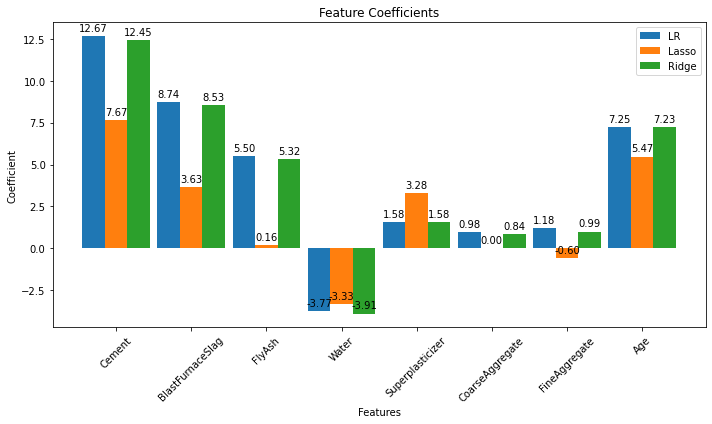

In [81]:
coeff_lr = lr.coef_
coeff_lasso = lasso.coef_
coeff_ridge = ridge.coef_

labels = req_col_names[:-1]

x = np.arange(len(labels)) 
width = 0.3

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 2*(width/2), coeff_lr, width, label='LR')
rects2 = ax.bar(x, coeff_lasso, width, label='Lasso')
rects3 = ax.bar(x + 2*(width/2), coeff_ridge, width, label='Ridge')

ax.set_ylabel('Coefficient')
ax.set_xlabel('Features')
ax.set_title('Feature Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

Lasso Regression, reduces the complexity of the model by keeping the coefficients as low as possible. Also, Coefficients with Linear and Ridge are almost same.

### Plotting Predictions

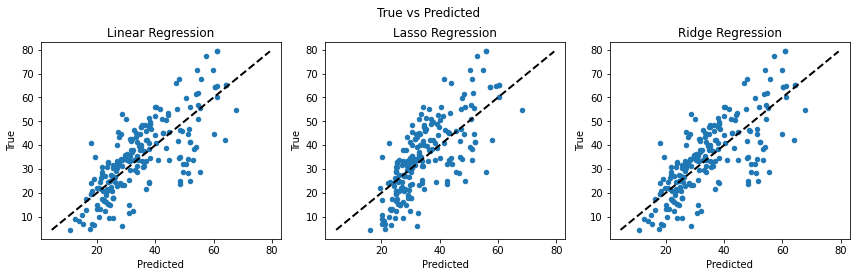

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.scatter(y_pred_lr, y_test, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_ylabel("True")
ax1.set_xlabel("Predicted")
ax1.set_title("Linear Regression")

ax2.scatter(y_pred_lasso, y_test, s=20)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_ylabel("True")
ax2.set_xlabel("Predicted")
ax2.set_title("Lasso Regression")

ax3.scatter(y_pred_ridge, y_test, s=20)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax3.set_ylabel("True")
ax3.set_xlabel("Predicted")
ax3.set_title("Ridge Regression")

fig.suptitle("True vs Predicted")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Looking at the graphs between predicted and true values of the target variable, we can conclude that Linear and Ridge Regression perform well as the predictions are closer to the actual values. While Lasso Regression reduces the complexity at the cost of loosing performance in this case. (The closer the points are to the black line, the less the error is.)

### Decision Trees

Another algorithm that would give better performance in this case would be Decision Trees, since we have a lot of zeros in some of the input features as seen from their distributions in the pair plot above. This would help the decision trees build trees based on some conditions on features which can further improve performance.

Model				 RMSE 		 MSE 		 MAE 		 R2
Decision Tree Regressor 	 7.34 		 53.91 		4.46 		0.78


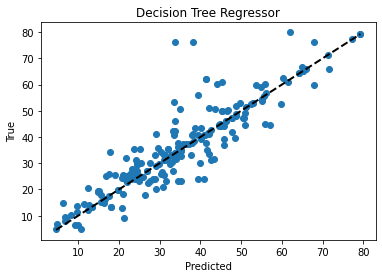

In [83]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

y_pred_dtr = dtr.predict(X_test)

print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""Decision Tree Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_dtr)),mean_squared_error(y_test, y_pred_dtr),
            mean_absolute_error(y_test, y_pred_dtr), r2_score(y_test, y_pred_dtr)))

plt.scatter(y_test, y_pred_dtr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Regressor")
plt.show()

The Root Mean Squared Error (RMSE) has come down from 10.29 to 7.31, so the Decision Tree Regressor has improved the performance by a substantial amount. This can be observed in the plot as well as more points are on the line.
Random Forest Regressor

Since Using a Decision Tree Regressor has improved our performance, we can further improve the performance by ensembling more trees. 

### Random Forest Regressor
The Random Forest Regressor trains randomly initialized trees with random subsets of data sampled from the training data, this should make our model more robust.

Model				 RMSE 		 MSE 		 MAE 		 R2
Random Forest Regressor 	 5.00 		 24.97 		3.39 		0.90


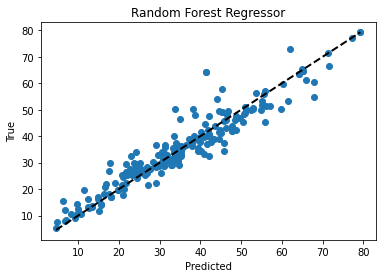

In [84]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)

rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""Random Forest Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred_rfr)),mean_squared_error(y_test, y_pred_rfr),
            mean_absolute_error(y_test, y_pred_rfr), r2_score(y_test, y_pred_rfr)))

plt.scatter(y_test, y_pred_rfr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Regressor")
plt.show()

The RMSE with Random Forest Regressor is now 5.11, we have reduced the error by ensembling multiple trees.

#### Feature importances for Decision Tree and Random Forest

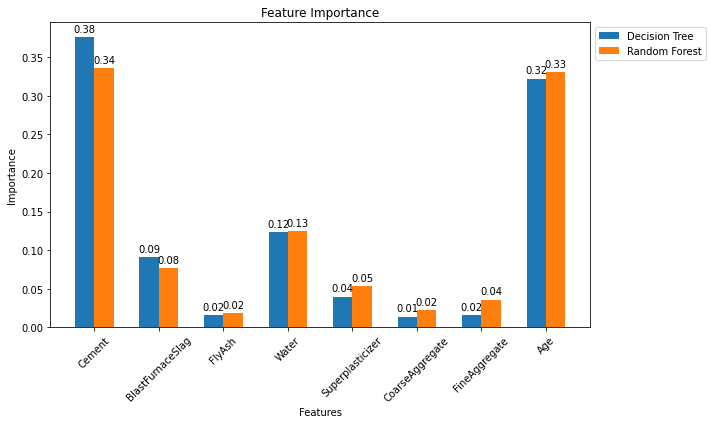

In [85]:
feature_dtr = dtr.feature_importances_
feature_rfr = rfr.feature_importances_

labels = req_col_names[:-1]

x = np.arange(len(labels)) 
width = 0.3

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x-(width/2), feature_dtr, width, label='Decision Tree')
rects2 = ax.bar(x+(width/2), feature_rfr, width, label='Random Forest')

ax.set_ylabel('Importance')
ax.set_xlabel('Features')
ax.set_title('Feature Importance')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Cement and Age are treated as the most important features by tree based models. Flyash, Coarse and Fine aggregates are least important factors when predicting the strength of Concrete.
Comparision

Finally, lets compare the results of all the algorithms.

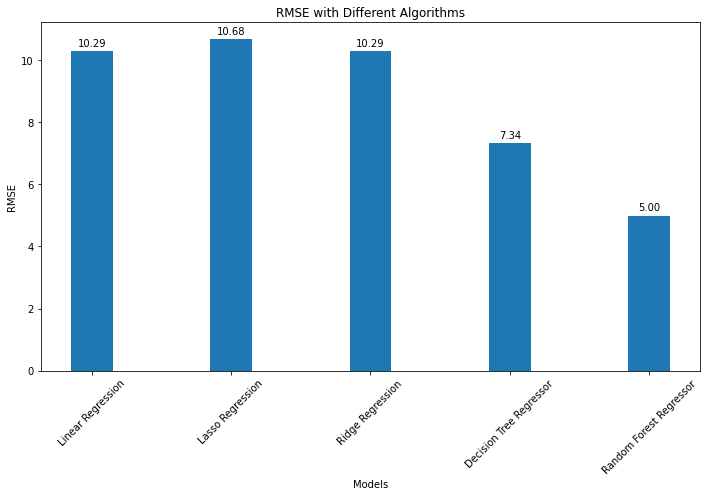

In [86]:
models = [lr, lasso, ridge, dtr, rfr]
names = ["Linear Regression", "Lasso Regression", "Ridge Regression", 
         "Decision Tree Regressor", "Random Forest Regressor"]
rmses = []

for model in models:
    rmses.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

x = np.arange(len(names)) 
width = 0.3

fig, ax = plt.subplots(figsize=(10,7))
rects = ax.bar(x, rmses, width)
ax.set_ylabel('RMSE')
ax.set_xlabel('Models')
ax.set_title('RMSE with Different Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45)
autolabel(rects)
fig.tight_layout()
plt.show()

## Conclusion

Random Forest Regressor is the best choice for this problem.

## Exercises
1) Add a user interface, that lets one enter a mixture and estimates the strength

2) Supply 5 mixtures, estimate strength 

2) Add these 5 to the database, examine  changes in model(s)
